## Question 4: Activity classification

The goal of this question is to design a very simple linear classifier based on mobile accelerometer sensor to discriminate between car and walking movements and implement it on device. The pipeline consists of data collection, feature extraction, and inference on short sensor segments.

The dataset for question 4 is very limited on purpose.  sensors.csv consists of one-minute segments, 10 for each class.  An accelerometer reading of a segment i has three acceleration axes called seg_i_x, seg_i_y, seg_i_z and one time axis called seg_i_taxis. The time axis is given in nanosecond since epoch. labels.csv allow the mapping between segment id and the corresponding label (0 for one class, 1 for the other)

The goal is to show your understanding of the problem, your way of reasoning, and your mobile programming skills. As the dataset is very limited, we don’t expect you to design an algorithm that will generalize efficiently.

1. Can you visualize the data and use it to intuitively deduce what label corresponds to walking and what label to car? Why?
2. What is the sampling rate of the signals? In order to denoise them, low pass filter was applied. What was, more or less, the cut-off frequency of the filter?
3. After a statistical analysis of the signals, define 2 features to compute per sensor segment that will allow an algorithm to discriminate between the two classes.
4. Train a simple 2-dimensional linear classifier (threshold function) on that dataset. Use the entire dataset for training; no need to use a validation or testing set.
5. Plot the two clusters on a 2-dimensional plane with the corresponding decision function.

Note: Acceleration units and conventions are different between iOS and Android. Take it into account if you port the pipeline on iOS as the training dataset has been collected on Android

In [1]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

E:\miniconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
sensor_df = pd.read_csv('sensors.csv', sep = ',')
labels_df = pd.read_csv('labels.csv', sep = ',')
labels_df = labels_df[['segment_id' , 'label']]

my_df_list = []
labels_dict = labels_df.to_dict()

for i in range(1,22):
    my_df_list.append(sensor_df[['seg_'+str(i)+'_x',
                                 'seg_'+str(i)+'_y',
                                 'seg_'+str(i)+'_z',
                                 'seg_'+str(i)+'_taxis']])
    my_df_list[i-1]['label'] = labels_dict['label'][i-1]
    my_df_list[i-1].dropna().to_numpy()

E:\miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


    In order to intuitively deduce which label might correspond to a person walking or which label corresponds to a person travelling by car,
    a plot of a random sample from each of them reveals the following:

    For a person walking, there would be sharper peaks in the accelerometer reading as the degree of motion os higher
    Think of a person walking with his phone in his pocket. The phone records his locations using the internal accelerometer.
    There would be a constant swaying action given the motion of his legs or arms in case of a wristband based accelerometer.

    For a person travelling by car, the accelerometer readings would be rather smooth since there are no strong motions while normally travelling by car.

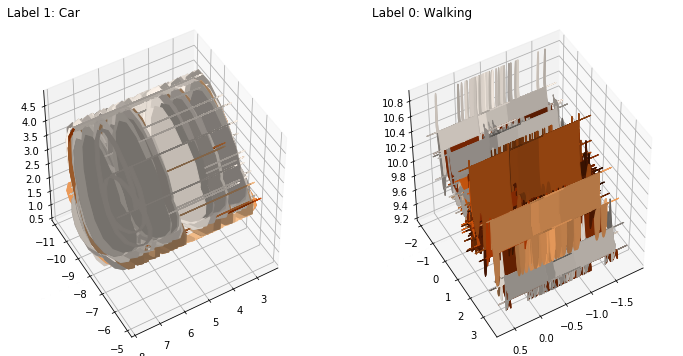

In [3]:
fig = plt.figure(figsize = (12, 6))

x = my_df_list[0][['seg_1_x']]
y = my_df_list[0][['seg_1_y']]
Z = my_df_list[0][['seg_1_z']]
# here are the x,y and respective z values
X, Y = np.meshgrid(x, y)
# this is the value to use for the color
V = np.sin(Y)

# create the figure, add a 3d axis, set the viewing angle

ax = fig.add_subplot(1,2,1, projection='3d')
ax.view_init(45,60)

# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
ax.plot_surface(X, Y, Z, facecolors = plt.cm.Oranges(V))
ax.set_title('Label 1: Car', loc = 'left')

x = my_df_list[20][['seg_21_x']]
y = my_df_list[20][['seg_21_y']]
Z = my_df_list[20][['seg_21_z']]
# here are the x,y and respective z values
X, Y = np.meshgrid(x, y)
# this is the value to use for the color
V = np.sin(Y)

# create the figure, add a 3d axis, set the viewing angle

ax = fig.add_subplot(1,2,2, projection='3d')
ax.view_init(45,60)

# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
ax.plot_surface(X, Y, Z, facecolors = plt.cm.Oranges(V))
ax.set_title('Label 0: Walking', loc = 'left')

plt.show()

    The sampling period can be found by taking the time difference between two consequtive samples.
    The sampling frequency would be the inverse of the sampling period, scaled to the nano range.

In [4]:
t1 = my_df_list[0][['seg_1_taxis']].iloc[1].values
t2 = my_df_list[0][['seg_1_taxis']].iloc[2].values

sampling_period = t2-t1
sampling_freq = (1/sampling_period) * 1000000000

print('Sampling frequency: {}Hz'.format(sampling_freq[0].round(3)))

Sampling frequency: 26.0Hz


    A filter is usually used to limit the rate of change of a signal. The maximum rate of change between two consequtive samples
    is given by the absolute difference between two values along any of the 3 axes divided by the sampling period, scaled to the nano range.
    I would presume this maximum rate of change would be related to the cut off frequency of the Low Pass Filter that was used.

In [5]:
nyquist_frequency = sampling_freq * 2
print('Nyquist frequency: {}Hz'.format(nyquist_frequency[0].round(3)))

x1 = my_df_list[0][['seg_1_x']].iloc[1].values
x2 = my_df_list[0][['seg_1_x']].iloc[2].values

max_rate_of_change = abs((x2-x1)/sampling_period) * 1000000000
print('Max rate of change: {}'.format(max_rate_of_change[0].round(3)))

Nyquist frequency: 52.0Hz
Max rate of change: 1.813


In [6]:
dataset_array = np.vstack(my_df_list)

X = dataset_array[:, 0:3]
y = dataset_array[:, 4:5]
y = y.reshape(y.shape[0])

    For training a simple Linear Classifier, we first scale and normalize the values followed by a dimensinality reduction technique
    for prominent features extraction.

    I use the Robust Scaler for scaling and normalizing since it is resilient to outliers, and the Incremental PCA for the dimensionality
    reduction. The Incremental PCA differs from the regular PCA from the fact that it does not center the values before applying value decomposition or
    Principal Component Analysis. This sort of helps preserve the underlying base structure and distances of and between the data points.

In [7]:
robust_scaler = RobustScaler()

In [8]:
incremental_pca = IncrementalPCA(n_components=2)

In [9]:
linear_clf = LinearSVC(tol = 1e-5)

In [10]:
clf = Pipeline([('scaling', robust_scaler),
                ('dimensionality_reduction', incremental_pca),
                ('classification', linear_clf)])

    A Scikit-Learn Pipeline is used to, well, pipeline all three aformentioned stages.
    The 'fit' method is called to process data through the pipeline and train the classifier.

In [11]:
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaling',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('dimensionality_reduction',
                 IncrementalPCA(batch_size=None, copy=True, n_components=2,
                                whiten=False)),
                ('classification',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=1e-05, verbose=0))],
         verbose=False)

In [12]:
def make_meshgrid(x, y, h = 0.02):

    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)

    return out

In [13]:
X = robust_scaler.fit_transform(X)
pca_reduced_X = incremental_pca.fit_transform(X)

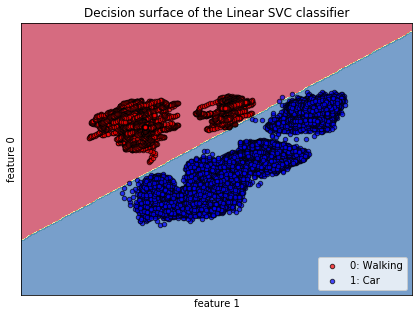

In [14]:
fig, ax = plt.subplots(figsize = (7, 5))

title = ('Decision surface of the Linear SVC classifier')

X0, X1 = pca_reduced_X[:, 0], pca_reduced_X[:, 1]
xx, yy = make_meshgrid(X0, X1)

X0_0, X0_1 = pca_reduced_X[y == 0][:, 0], pca_reduced_X[y == 0][:, 1]
X1_0, X1_1 = pca_reduced_X[y == 1][:, 0], pca_reduced_X[y == 1][:, 1]

plot_contours(ax, linear_clf, xx, yy, cmap = plt.cm.Spectral, alpha = 0.7)

ax.scatter(X0_0, X0_1, c = 'r', s = 20, edgecolors = 'k', alpha = 0.7, label = '0: Walking')
ax.scatter(X1_0, X1_1, c = 'b', s = 20, edgecolors = 'k', alpha = 0.7, label = '1: Car')
ax.set_ylabel('feature 0')
ax.set_xlabel('feature 1')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(title)
ax.legend(loc = 'lower right')

plt.show()

In [15]:
# export pipeline for mobile devices.
joblib.dump(clf, 'classifier_pipeline.joblib')

['classifier_pipeline.joblib']